In [1]:
import os
import random
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from src.train import train, plot_metrics
from models.conditioned_eegnet import ConditionedEEGNet
from src.dataset.MI_dataset_single_subject import MI_Dataset
from config.default import cfg


from utils.eval import accuracy
from utils.model import print_parameters, print_weights_statistics

%load_ext autoreload
%autoreload 2


In [2]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
train_dataset = MI_Dataset.get_dataset(cfg, split='train', return_subject_id = True, device=device, verbose=False)
train_dataloader = DataLoader(train_dataset, batch_size=cfg['train']['batch_size'], shuffle=True)
print(f"Train dataset: {len(train_dataset)} samples")

test_dataset = MI_Dataset.get_dataset(cfg, split='test', return_subject_id = True, device=device, verbose=False)
test_dataloader = DataLoader(test_dataset, batch_size=cfg['train']['batch_size'], shuffle=False)
print(f"Test dataset: {len(test_dataset)} samples")

Loading dataset from cache\all_subjects_with_id\train_dataset.pkl...
Train dataset: 2016 samples
Loading dataset from cache\all_subjects_with_id\test_dataset.pkl...
Test dataset: 432 samples


In [5]:
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

for feature, label in train_dataloader:
    print(feature[0].shape)
    print(feature[1].shape)
    print(label.shape)
    print(feature[1])
    break

Train dataset: 2016 samples
Test dataset: 432 samples
torch.Size([64, 22, 401])
torch.Size([64])
torch.Size([64])
tensor([0, 2, 0, 4, 2, 0, 3, 6, 5, 5, 8, 6, 7, 0, 4, 2, 4, 8, 0, 1, 4, 8, 5, 4,
        5, 4, 4, 5, 0, 5, 1, 4, 7, 8, 7, 3, 2, 2, 8, 1, 6, 0, 8, 2, 1, 0, 0, 3,
        3, 4, 5, 5, 5, 7, 8, 2, 7, 1, 2, 4, 0, 4, 1, 7], device='cuda:0')


In [6]:
model = ConditionedEEGNet.from_config(cfg['model'], device)
print_parameters(model)

eeg_processor.conv1.weight.... --> 250
eeg_processor.bn1.weight...... --> 25
eeg_processor.bn1.bias........ --> 25
eeg_processor.dw_conv1.weight. --> 1100
eeg_processor.bn2.weight...... --> 50
eeg_processor.bn2.bias........ --> 50
eeg_processor.sep_conv1.weight --> 800
eeg_processor.conv2.weight.... --> 1250
eeg_processor.bn3.weight...... --> 25
eeg_processor.bn3.bias........ --> 25
subject_processor.fn1.weight.. --> 225
subject_processor.fn1.bias.... --> 25
subject_norm.weight........... --> 25
subject_norm.bias............. --> 25
eeg_norm.weight............... --> 300
eeg_norm.bias................. --> 300
attn_norm.weight.............. --> 8
attn_norm.bias................ --> 8
query.weight.................. --> 2400
key.weight.................... --> 200
value.weight.................. --> 200
fn1.weight.................... --> 512
fn1.bias...................... --> 64
fn2.weight.................... --> 256
fn2.bias...................... --> 4
eeg_fn.weight................. --> 240

In [7]:
loss, val_loss, train_acc, val_acc = train(model, train_dataloader, test_dataloader, cfg['train'])

Epoch 10/100, Loss: 1.4504817984998226, Val Loss: 1.481888277190072, Train accuracy: 31.50%, Test accuracy: 30.79%
Epoch 20/100, Loss: 1.2935534305870533, Val Loss: 1.353584953716823, Train accuracy: 36.21%, Test accuracy: 33.10%
Epoch 30/100, Loss: 1.2507445141673088, Val Loss: 1.3124457086835588, Train accuracy: 41.72%, Test accuracy: 34.95%
Epoch 40/100, Loss: 1.2034686021506786, Val Loss: 1.2974371910095215, Train accuracy: 46.73%, Test accuracy: 40.74%
Epoch 50/100, Loss: 1.1529823690652847, Val Loss: 1.2754101242337907, Train accuracy: 50.64%, Test accuracy: 40.05%
Epoch 60/100, Loss: 1.1092248260974884, Val Loss: 1.2994243928364344, Train accuracy: 53.92%, Test accuracy: 44.68%
Epoch 70/100, Loss: 1.0653237979859114, Val Loss: 1.3024547014917647, Train accuracy: 54.12%, Test accuracy: 38.43%
Epoch 80/100, Loss: 1.0330943036824465, Val Loss: 1.279910581452506, Train accuracy: 56.80%, Test accuracy: 42.36%
Epoch 90/100, Loss: 1.0187145229429007, Val Loss: 1.3633739607674735, Train

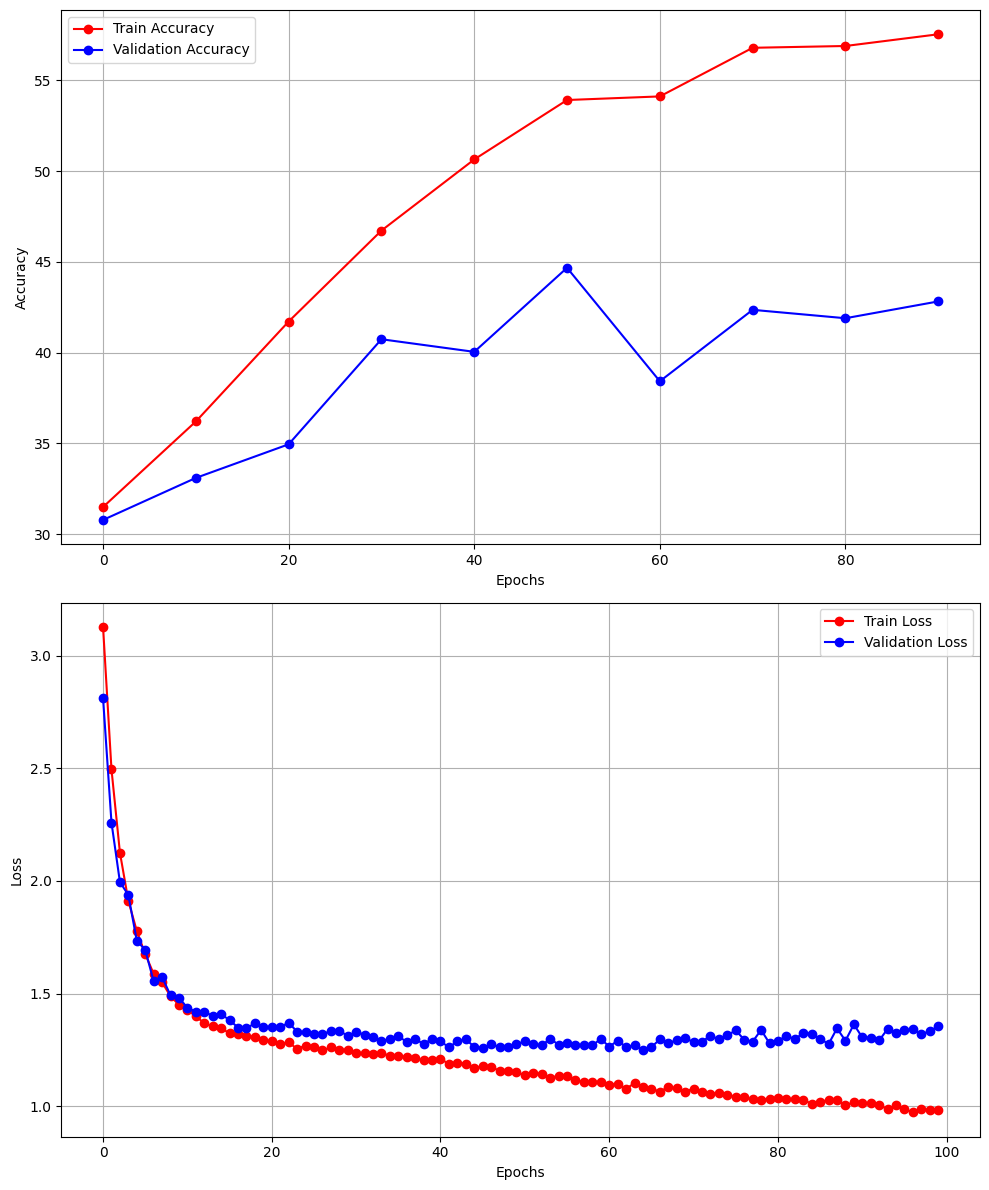

In [8]:
plot_metrics(loss, val_loss, train_acc, val_acc)